# Giffler-Thompson Algorithmus

In [1]:
import utils.converter as convert
import utils.presenter as show
import utils.checker as check

In [2]:
import json
import random
import pandas as pd
from collections import defaultdict

In [3]:
import time

In [4]:
main_file_path = "../main_data/{}"

In [5]:
# Datei laden
with open(main_file_path.format("jobshop_instances.json"), "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


1. **Initialisierung**:

   * Setze Startzeit jedes Jobs und Maschinenverfügbarkeit auf 0.
   * Markiere erste Operation jedes Jobs als „bereit zur Planung“.

2. **Solange noch nicht alle Operationen eingeplant sind**:

   1. Bestimme für jede verfügbare Operation die **frühestmögliche Startzeit** (unter Berücksichtigung von Maschinenverfügbarkeit und Vorgängeroperationen).
   2. Wähle die Operation mit dem **frühesten frühestmöglichen Endzeitpunkt** (**Earliest Completion Time**, ECT).
   3. Identifiziere die **Konfliktmenge**: alle anderen Operationen, die auf derselben Maschine zum gleichen Zeitpunkt starten könnten.
   4. **Wähle eine Operation** aus der Konfliktmenge nach einer **Prioritätsregel** (z. B. SPT – Shortest Processing Time).
   5. **Plane diese Operation ein**:

      * Weise ihr Start- und Endzeit zu.
      * Aktualisiere Maschinenverfügbarkeit.
      * Markiere die Nachfolgeoperation im Job als „bereit“, wenn möglich.

3. **Wiederholen**, bis alle Operationen eingeplant sind.

In [6]:
import pandas as pd
import random
from collections import defaultdict

def giffler_thompson_schedule(df_jssp: pd.DataFrame, priority_rule: str = "SPT", log_on = True) -> pd.DataFrame:
    """
    Giffler-Thompson-Algorithmus zur Erstellung eines zulässigen JSSP-Zeitplans.
    
    Parameter:
    - df_jssp: DataFrame mit ['Job', 'Operation', 'Machine', 'Processing Time']
    - priority_rule: "SPT" (Shortest Processing Time) oder "FCFS" (First Come First Serve)

    Rückgabe:
    - df_schedule: DataFrame mit ['Job','Operation','Machine','Start','Processing Time','End']
    """
    if log_on: 
        print(f'Giffler-Thomson-Algorthmus mit Prioritätsregel "{priority_rule}" gestartet ...\n')
    
    # Vorbereitung
    df = df_jssp.copy().sort_values(['Job', 'Operation']).reset_index(drop=True)
    machines = set(df['Machine'])
    jobs = df['Job'].unique()

    # Zeitstatus
    job_op_ready = {job: 0 for job in jobs}
    machine_available = {m: 0 for m in machines}
    job_op_index = {job: 0 for job in jobs}

    # Operationen vorbereiten
    job_ops = defaultdict(list)
    for _, row in df.iterrows():
        job_ops[row['Job']].append((row['Operation'], row['Machine'], row['Processing Time']))

    result = []
    remaining = sum(len(v) for v in job_ops.values())

    while remaining > 0:
        candidates = []
        for job in jobs:
            idx = job_op_index[job]
            if idx < len(job_ops[job]):
                op_id, m, d = job_ops[job][idx]
                est = max(job_op_ready[job], machine_available[m])
                candidates.append((est, d, job, op_id, m))

        # Finde frühest möglichen Konfliktzeitpunkt
        min_est = min(c[0] for c in candidates)
        conflict_ops = [c for c in candidates if c[0] == min_est]

        # Wähle nach Prioritätsregel
        if priority_rule == "SPT":
            selected = min(conflict_ops, key=lambda x: x[1])  # kürzeste Dauer
        elif priority_rule == "LPT":
            selected = max(conflict_ops, key=lambda x: x[1])  # längste Dauer
        elif priority_rule == "FCFS":
            selected = conflict_ops[0]                        # erste im Konflikt
        else:  # RANDOM
            selected = random.choice(conflict_ops)            # zufällige Auswahl

        est, d, job, op_id, m = selected
        start = est
        end = start + d
        result.append({
            'Job': job,
            'Operation': op_id,
            'Machine': m,
            'Start': start,
            'Processing Time': d,
            'End': end
        })

        # Zeitstatus aktualisieren
        job_op_ready[job] = end
        machine_available[m] = end
        job_op_index[job] += 1
        remaining -= 1

    df_schedule = pd.DataFrame(result).sort_values(['Start', 'Job', 'Operation']).reset_index(drop=True)
    makespan = df_schedule['End'].max()
    
    # Logging
    if log_on: 
        print("\nPlan-Informationen:")
        print(f"  Anzahl Jobs        : {len(jobs)}")
        print(f"  Anzahl Maschinen   : {len(machines)}")
        print(f"  Anzahl Operationen : {len(df_schedule)}")
        print(f"  Makespan           : {makespan}")
        
    return df_schedule, makespan



### a) SPT

In [7]:
starting_time = time.time()

# Scheduling
df_plan, makespan = giffler_thompson_schedule(df_instance)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.4f} Sekunden.")
df_plan

Giffler-Thomson-Algorthmus mit Prioritätsregel "SPT" gestartet ...


Plan-Informationen:
  Anzahl Jobs        : 10
  Anzahl Maschinen   : 10
  Anzahl Operationen : 100
  Makespan           : 1074

Scheduling-Dauer: 0 Minuten und 0.0052 Sekunden.


,Job,Operation,Machine,Start,Processing Time,End
0,job 0,0,M0,0,29,29
1,job 4,0,M2,0,14,14
2,job 6,0,M1,0,46,46
3,job 7,0,M2,14,31,45
4,job 4,1,M0,29,6,35
...,...,...,...,...,...,...
95,job 3,9,M5,943,43,986
96,job 7,9,M3,943,79,1022
97,job 9,9,M7,943,45,988
98,job 2,8,M9,996,45,1041


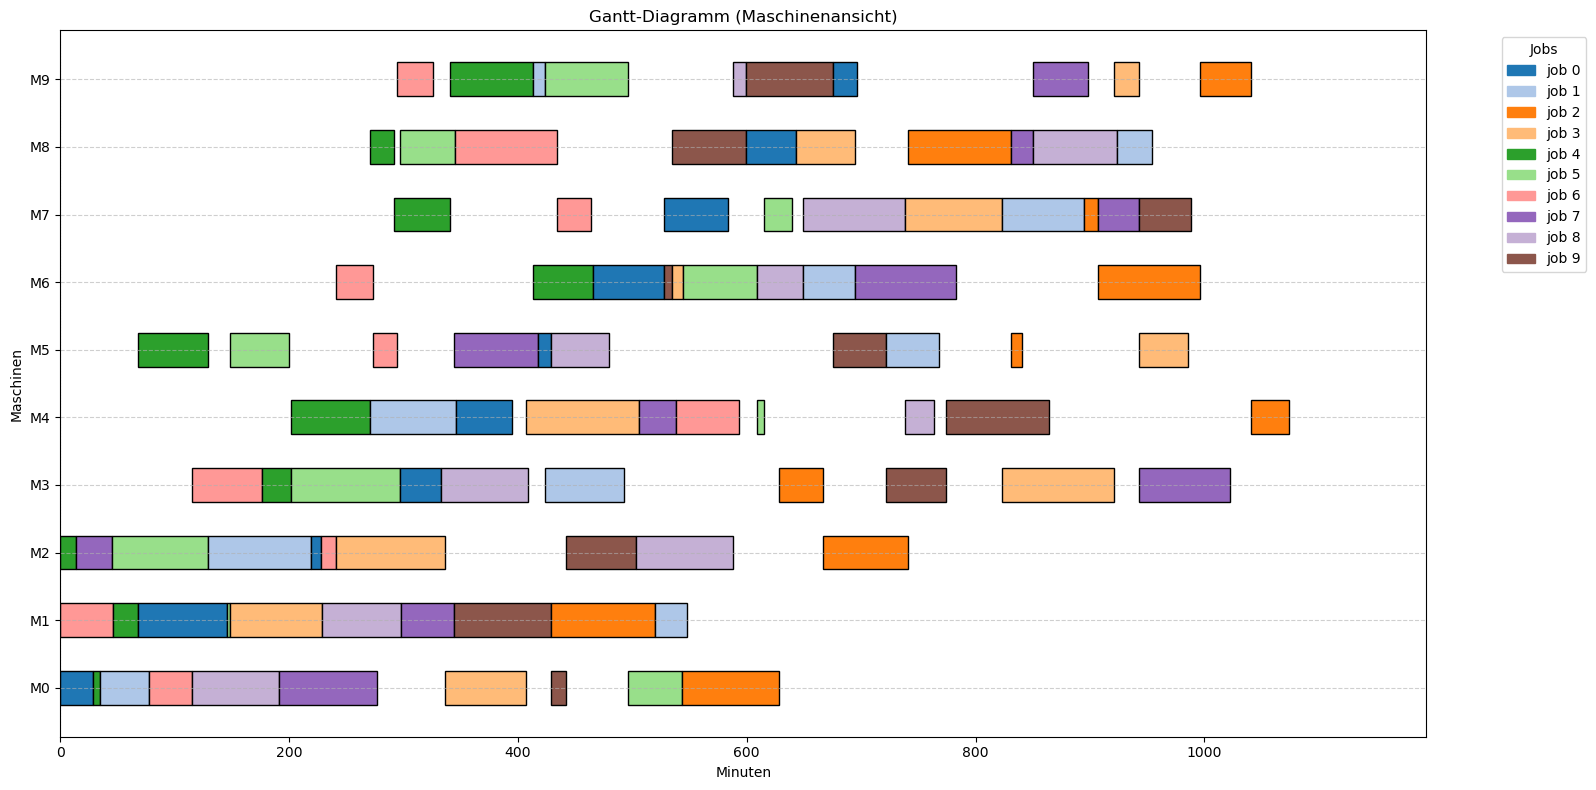

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.


True

In [8]:
show.plot_gantt_machines(df_plan)
check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)


### b) FCFS

In [9]:
starting_time = time.time()

# Scheduling
df_plan, makespan = giffler_thompson_schedule(df_instance,priority_rule="FCFS")

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.4f} Sekunden.")
df_plan

Giffler-Thomson-Algorthmus mit Prioritätsregel "FCFS" gestartet ...


Plan-Informationen:
  Anzahl Jobs        : 10
  Anzahl Maschinen   : 10
  Anzahl Operationen : 100
  Makespan           : 1262

Scheduling-Dauer: 0 Minuten und 0.0036 Sekunden.


,Job,Operation,Machine,Start,Processing Time,End
0,job 0,0,M0,0,29,29
1,job 2,0,M1,0,91,91
2,job 4,0,M2,0,14,14
3,job 5,0,M2,14,84,98
4,job 1,0,M0,29,43,72
...,...,...,...,...,...,...
95,job 9,7,M3,1075,52,1127
96,job 8,8,M4,1093,26,1119
97,job 8,9,M8,1119,74,1193
98,job 9,8,M4,1127,90,1217


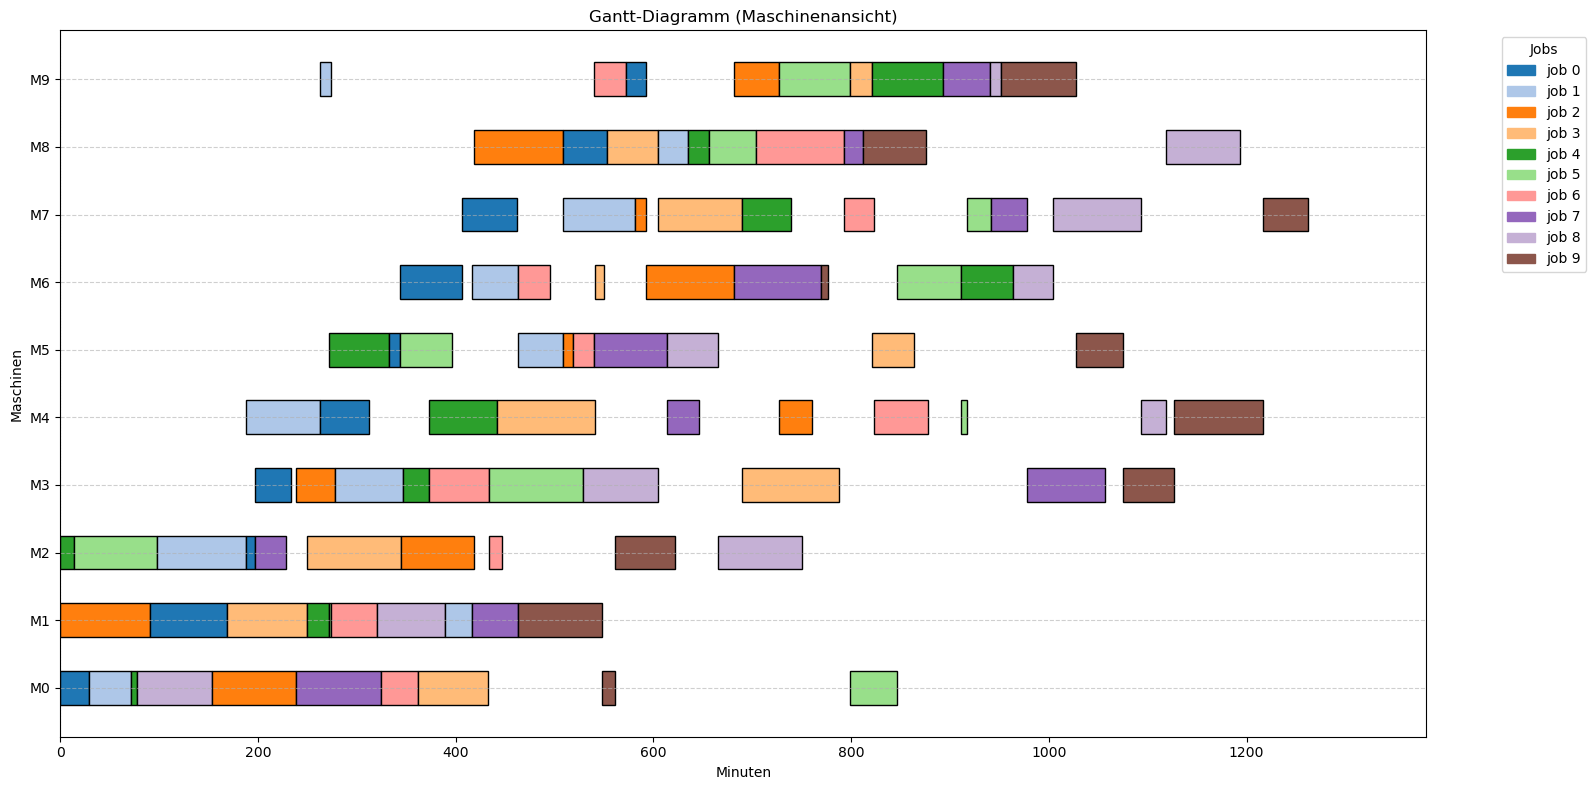

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.


True

In [10]:
show.plot_gantt_machines(df_plan)
check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)

### c) LPT

In [11]:
starting_time = time.time()

# Scheduling
df_plan, makespan = giffler_thompson_schedule(df_instance,priority_rule="LPT")

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.4f} Sekunden.")
df_plan

Giffler-Thomson-Algorthmus mit Prioritätsregel "LPT" gestartet ...


Plan-Informationen:
  Anzahl Jobs        : 10
  Anzahl Maschinen   : 10
  Anzahl Operationen : 100
  Makespan           : 1295

Scheduling-Dauer: 0 Minuten und 0.0033 Sekunden.


,Job,Operation,Machine,Start,Processing Time,End
0,job 2,0,M1,0,91,91
1,job 5,0,M2,0,84,84
2,job 8,0,M0,0,76,76
3,job 1,0,M0,76,43,119
4,job 7,0,M2,84,31,115
...,...,...,...,...,...,...
95,job 2,8,M9,1186,45,1231
96,job 5,7,M6,1186,65,1251
97,job 2,9,M4,1231,33,1264
98,job 5,8,M4,1264,6,1270


### d) Random

In [12]:
starting_time = time.time()

# Scheduling
df_plan, makespan = giffler_thompson_schedule(df_instance,priority_rule="RANDOM")

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.4f} Sekunden.")
df_plan

Giffler-Thomson-Algorthmus mit Prioritätsregel "RANDOM" gestartet ...


Plan-Informationen:
  Anzahl Jobs        : 10
  Anzahl Maschinen   : 10
  Anzahl Operationen : 100
  Makespan           : 1259

Scheduling-Dauer: 0 Minuten und 0.0035 Sekunden.


,Job,Operation,Machine,Start,Processing Time,End
0,job 0,0,M0,0,29,29
1,job 3,0,M1,0,81,81
2,job 4,0,M2,0,14,14
3,job 5,0,M2,14,84,98
4,job 8,0,M0,29,76,105
...,...,...,...,...,...,...
95,job 7,8,M7,1105,36,1141
96,job 1,7,M5,1111,46,1157
97,job 7,9,M3,1141,79,1220
98,job 1,8,M7,1157,72,1229


In [13]:
best_makespan = float('inf')
best_plan = None

start_time = time.time()

for i in range(500):
    df_plan, makespan = giffler_thompson_schedule(df_instance, priority_rule="RANDOM",log_on= False)
    
    if makespan < best_makespan:
        best_makespan = makespan
        best_plan = df_plan  # direkte Referenz – keine Liste nötig

end_time = time.time()


In [14]:
# Beste Lösung finden
print(f"Kleinster Makespan     : {best_makespan}")

Kleinster Makespan     : 1046


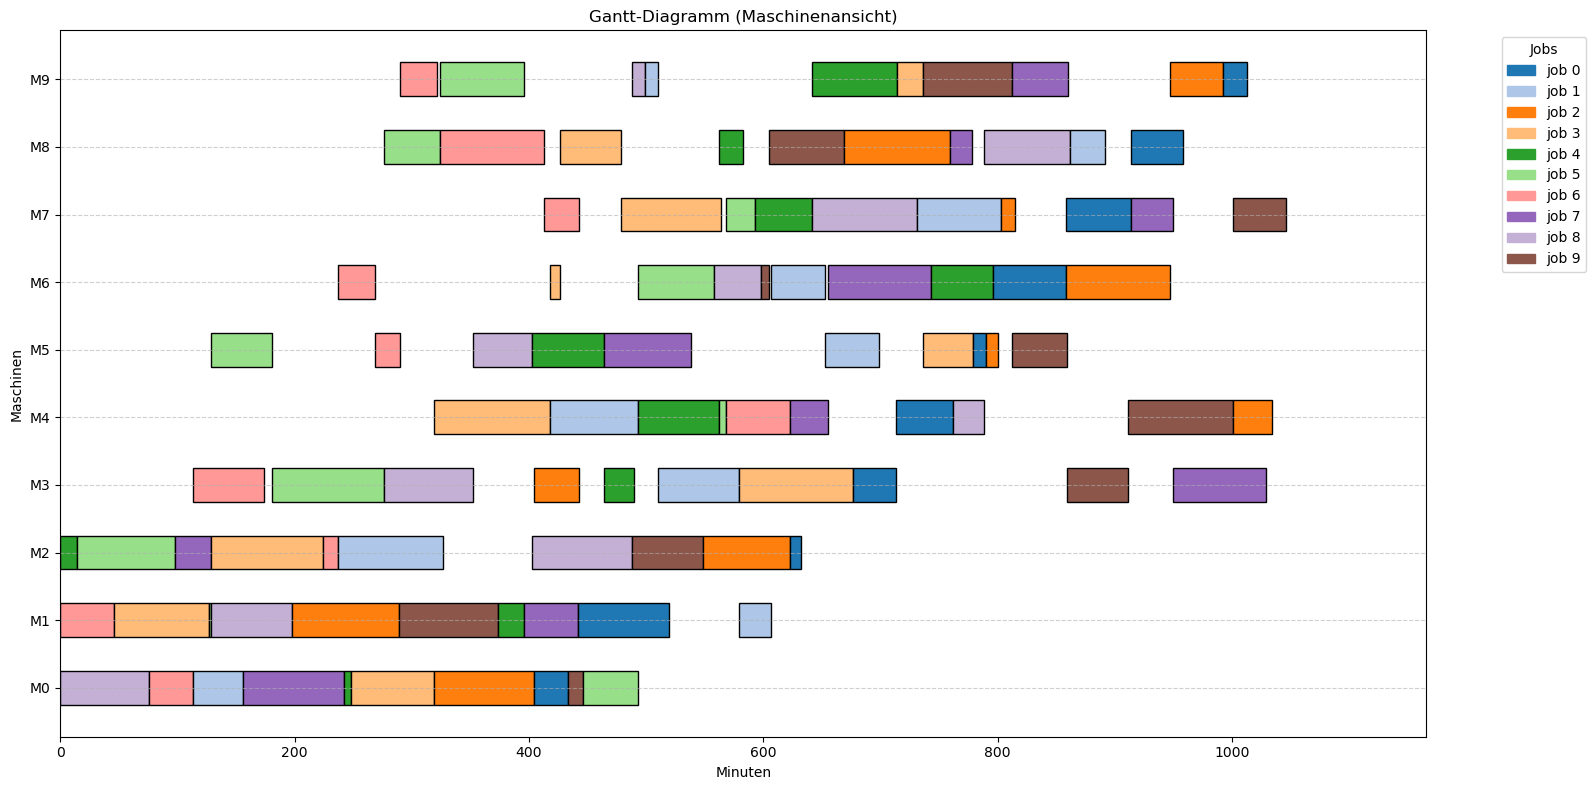

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.


True

In [15]:
df_plan = best_plan
show.plot_gantt_machines(df_plan)
check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)